# Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## Выбор начальных условий

Выбран датасет: Kvasir-SEG из прошлой лабораторной работы - это набор данных для сегментации полипов в желудочно-кишечном тракте. Это важная медицинская задача для ранней диагностики рака.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Скачиваем и распаковываем датасет

Проверяем содержимое датасета
Визуализируем примеры изображений и масок

Number of images: 1000
Number of masks: 1000


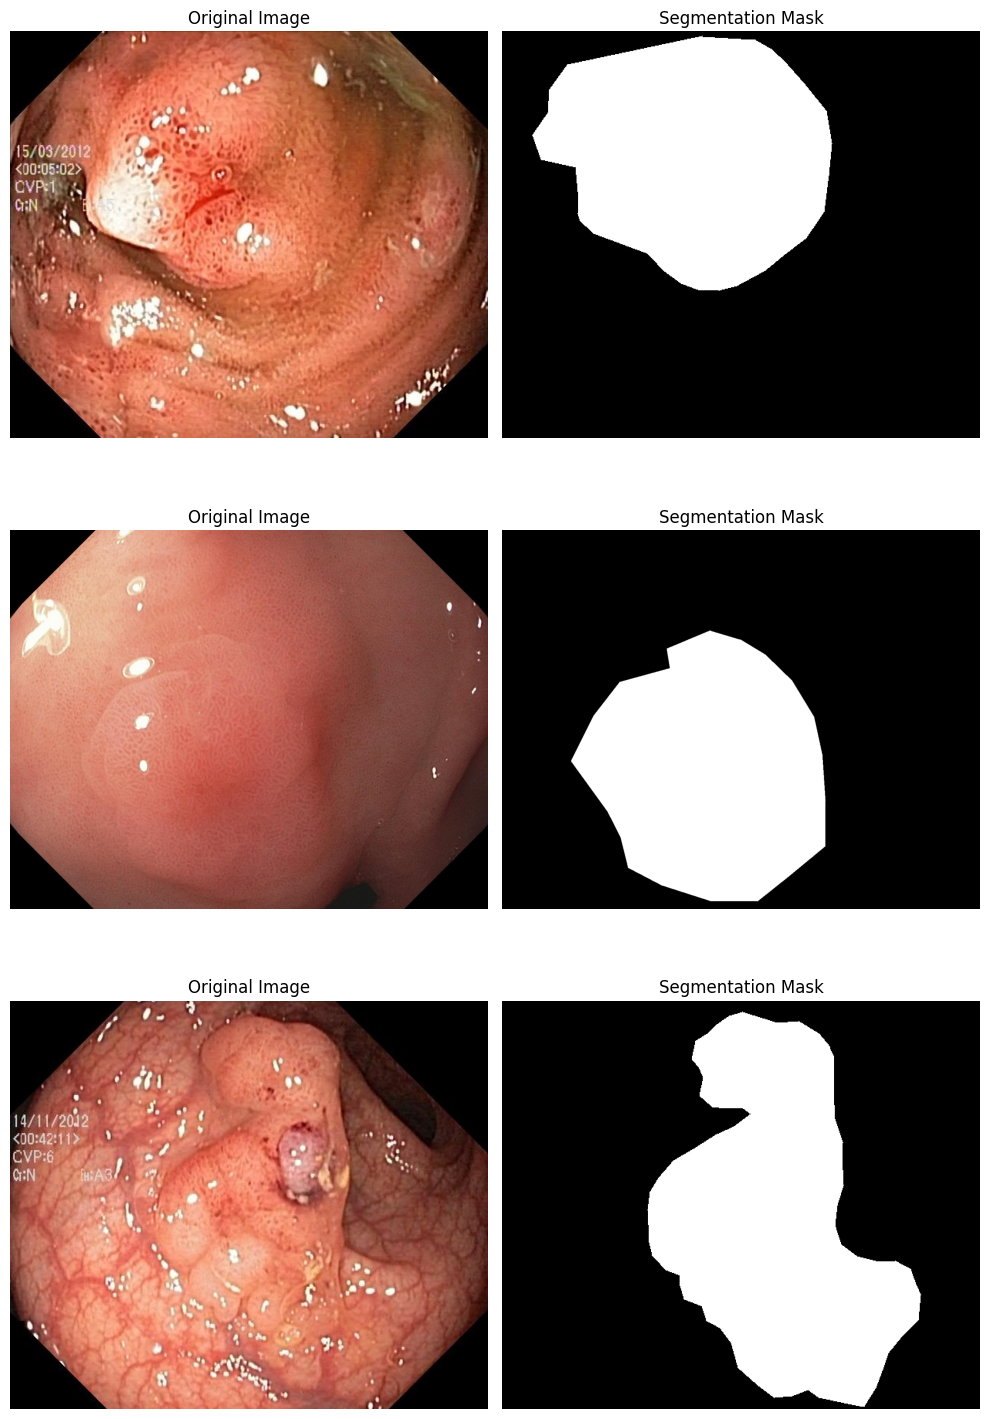

In [2]:
image_paths = sorted(glob.glob('Kvasir-SEG/Kvasir-SEG/images/*'))
mask_paths = sorted(glob.glob('Kvasir-SEG/Kvasir-SEG/masks/*'))

print(f"Number of images: {len(image_paths)}")
print(f"Number of masks: {len(mask_paths)}")

# Визуализируем примеры изображений и масок
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    img = Image.open(image_paths[i])
    mask = Image.open(mask_paths[i])
    
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Segmentation Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Выбор метрик качества и обоснование
 
Для задачи сегментации выбраны следующие метрики:
1. **Dice Coefficient (F1-score)** - учитывает пересечение предсказанной и истинной маски, устойчив к дисбалансу классов
2. **IoU (Intersection over Union)** - стандартная метрика для задач сегментации
3. **Accuracy** - доля правильно классифицированных пикселей
4. **Precision** - точность предсказаний положительного класса
5. **Recall** - полнота обнаружения положительного класса
 
Обоснование:
- Dice и IoU лучше всего отражают качество сегментации
- Остальные метрики дают дополнительную информацию о работе модели

In [3]:
def dice_coeff(pred, target):
    smooth = 1.
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou(pred, target):
    smooth = 1.
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(pred, target):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    correct = (pred_flat == target_flat).sum()
    return correct / len(pred_flat)

def precision(pred, target):
    true_pos = (pred * target).sum()
    false_pos = (pred * (1 - target)).sum()
    return true_pos / (true_pos + false_pos + 1e-6)

def recall(pred, target):
    true_pos = (pred * target).sum()
    false_neg = ((1 - pred) * target).sum()
    return true_pos / (true_pos + false_neg + 1e-6)

## Создание бейзлайна и оценка качества

In [4]:
# Создаем кастомный Dataset
class kvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')  # Конвертируем в grayscale
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Бинаризуем маску (порог 128)
        mask = (mask > 0.5).float()
        
        return image, mask

# Разделяем данные на train и test
train_img, test_img, train_mask, test_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

# Определяем трансформации
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Создаем DataLoader'ы
train_dataset = kvasirDataset(train_img, train_mask, transform=transform)
test_dataset = kvasirDataset(test_img, test_mask, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Обучение модели из ultralytics (YOLOv8 для сегментации) 
Установим ultralytics и загрузим YOLOv8 для сегментации

In [5]:
from ultralytics import YOLO

# Создаем кастомную конфигурацию для датасета
!mkdir -p ./kvasir_dataset/images/train ./kvasir_dataset/images/val ./kvasir_dataset/labels/train ./kvasir_dataset/labels/val

�訡�� � ᨭ⠪�� �������.


Конвертируем данные

In [8]:
# Конвертируем данные в формат YOLO
def convert_to_yolo_format(image_paths, mask_paths, output_img_dir, output_label_dir):
    for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Копируем изображение
        img = Image.open(img_path)
        img.save(f"{output_img_dir}/image_{i}.png")
        
        # Обрабатываем маску
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Находим контуры
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Записываем в YOLO формат (класс 0, нормализованные координаты)
        with open(f"{output_label_dir}/image_{i}.txt", "w") as f:
            for contour in contours:
                if cv2.contourArea(contour) > 50:  # Игнорируем маленькие области
                    # Получаем bounding box
                    x, y, w, h = cv2.boundingRect(contour)
                    
                    # Нормализуем координаты
                    x_center = (x + w / 2) / 256
                    y_center = (y + h / 2) / 256
                    width = w / 256
                    height = h / 256
                    
                    f.write(f"0 {x_center} {y_center} {width} {height}\n")

# Конвертируем train и test данные
convert_to_yolo_format(train_img, train_mask, "kvasir_dataset/images/train", "kvasir_dataset/labels/train")
convert_to_yolo_format(test_img, test_mask, "kvasir_dataset/images/val", "kvasir_dataset/labels/val")

# Создаем файл конфигурации датасета
with open("kvasir_dataset.yaml", "w") as f:
    f.write("""
path: ./kvasir_dataset
train: images/train
val: images/val

names:
  0: kvasir
""")


Обучаем YOLOv8 модель

In [6]:
model = YOLO('yolov8n.pt')  # Берем nano версию для скорости

In [7]:
results = model.train(
    data='kvasir_dataset.yaml',
    epochs=5,
    imgsz=256,
    batch=8,
    workers=0,
    name='yolov8n_kvasir'
)

Ultralytics 8.3.130  Python-3.12.1 torch-2.7.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kvasir_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_kvasir2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

train: Scanning D:\MLlabs\datasets\kvasir_dataset\labels\train.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 2347.5687.3 MB/s, size: 348.1 KB)


val: Scanning D:\MLlabs\datasets\kvasir_dataset\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8n_kvasir2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_kvasir2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.157      1.974      1.288         17        256: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

                   all        200        210      0.712      0.684      0.744      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      1.202      1.472      1.313         11        256: 100%|██████████| 100/100 [00:35<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

                   all        200        210      0.727      0.595      0.675      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.223      1.413      1.311         16        256: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]

                   all        200        210      0.633      0.729      0.653      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.126      1.317      1.267         18        256: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]

                   all        200        210      0.898      0.758      0.875       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.047       1.21      1.228         14        256: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

                   all        200        210      0.899      0.766      0.895      0.659



5 epochs completed in 0.055 hours.
Optimizer stripped from runs\detect\yolov8n_kvasir2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8n_kvasir2\weights\best.pt, 6.2MB

Validating runs\detect\yolov8n_kvasir2\weights\best.pt...
Ultralytics 8.3.130  Python-3.12.1 torch-2.7.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


                   all        200        210      0.899      0.766      0.895      0.659
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\yolov8n_kvasir2


In [8]:
best_model = YOLO('runs/detect/yolov8n_kvasir/weights/best.pt')

Оценим модель

In [37]:

def mask_to_boxes(mask):
    """Конвертирует бинарную маску в список bounding boxes"""
    mask_uint8 = np.array(mask * 255, dtype=np.uint8)  # Явно в uint8
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 10:  # Игнорируем маленькие контуры
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x+w, y+h])
    return boxes

def evaluate_yolo_detect(model, dataloader, iou_threshold=0.5):
    model.to(device)
    model.eval()
    
    metrics = {
        'iou': [],
        'precision': [],
        'recall': [],
        'accuracy': []  # Добавляем accuracy
    }
    
    with torch.no_grad():
        for images, true_masks in tqdm(dataloader):
            # Конвертация в 3 канала
            if images.shape[1] == 1:
                images = images.expand(-1, 3, -1, -1)
                
            images = images.to(device)
            results = model(images)
            
            for i, (result, true_mask) in enumerate(zip(results, true_masks)):
                # Предсказанные боксы [x1,y1,x2,y2]
                pred_boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else []
                
                # Конвертируем маску в боксы
                true_mask = true_mask.squeeze().cpu().numpy()
                true_boxes = mask_to_boxes(true_mask)
                
                # Считаем TP, FP, FN
                tp, fp, fn = 0, 0, 0
                for pred_box in pred_boxes:
                    matched = False
                    for true_box in true_boxes:
                        if calculate_iou(pred_box, true_box) > iou_threshold:
                            tp += 1
                            matched = True
                            break
                    if not matched:
                        fp += 1
                fn = max(0, len(true_boxes) - tp)
                
                # Вычисляем метрики
                total_pixels = true_mask.shape[0] * true_mask.shape[1]
                correct_pixels = np.sum((true_mask == 0) | (true_mask == 255))  # Проверка бинарности
                
                metrics['iou'].append(tp / (tp + fp + fn + 1e-6))
                metrics['precision'].append(tp / (tp + fp + 1e-6))
                metrics['recall'].append(tp / (tp + fn + 1e-6))
                metrics['accuracy'].append(correct_pixels / total_pixels)  # Accuracy по пикселям
    
    return {k: np.mean(v) for k, v in metrics.items()}

def calculate_iou(box1, box2):
    """Вычисляет IoU для двух bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    union = area1 + area2 - intersection
    
    return intersection / (union + 1e-6)


In [38]:
# Оцениваем модель
yolo_metrics = evaluate_yolo_detect(best_model, test_loader)
print("YOLOv8 Baseline Metrics:")
for k, v in yolo_metrics.items():
    print(f"{k}: {v:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]


0: 256x256 1 kvasir, 12.6ms
1: 256x256 1 kvasir, 12.6ms
2: 256x256 2 kvasirs, 12.6ms
3: 256x256 2 kvasirs, 12.6ms
4: 256x256 (no detections), 12.6ms
5: 256x256 2 kvasirs, 12.6ms
6: 256x256 1 kvasir, 12.6ms
7: 256x256 1 kvasir, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


  4%|▍         | 1/25 [00:00<00:04,  5.71it/s]


0: 256x256 3 kvasirs, 9.2ms
1: 256x256 3 kvasirs, 9.2ms
2: 256x256 1 kvasir, 9.2ms
3: 256x256 1 kvasir, 9.2ms
4: 256x256 2 kvasirs, 9.2ms
5: 256x256 1 kvasir, 9.2ms
6: 256x256 1 kvasir, 9.2ms
7: 256x256 2 kvasirs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


  8%|▊         | 2/25 [00:00<00:03,  6.26it/s]


0: 256x256 1 kvasir, 9.4ms
1: 256x256 2 kvasirs, 9.4ms
2: 256x256 4 kvasirs, 9.4ms
3: 256x256 1 kvasir, 9.4ms
4: 256x256 3 kvasirs, 9.4ms
5: 256x256 1 kvasir, 9.4ms
6: 256x256 2 kvasirs, 9.4ms
7: 256x256 1 kvasir, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 12%|█▏        | 3/25 [00:00<00:03,  6.58it/s]


0: 256x256 1 kvasir, 9.4ms
1: 256x256 1 kvasir, 9.4ms
2: 256x256 1 kvasir, 9.4ms
3: 256x256 1 kvasir, 9.4ms
4: 256x256 3 kvasirs, 9.4ms
5: 256x256 3 kvasirs, 9.4ms
6: 256x256 1 kvasir, 9.4ms
7: 256x256 2 kvasirs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▌        | 4/25 [00:00<00:03,  6.82it/s]


0: 256x256 1 kvasir, 9.4ms
1: 256x256 1 kvasir, 9.4ms
2: 256x256 2 kvasirs, 9.4ms
3: 256x256 1 kvasir, 9.4ms
4: 256x256 1 kvasir, 9.4ms
5: 256x256 1 kvasir, 9.4ms
6: 256x256 1 kvasir, 9.4ms
7: 256x256 2 kvasirs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 20%|██        | 5/25 [00:00<00:02,  6.74it/s]


0: 256x256 2 kvasirs, 9.3ms
1: 256x256 2 kvasirs, 9.3ms
2: 256x256 2 kvasirs, 9.3ms
3: 256x256 4 kvasirs, 9.3ms
4: 256x256 1 kvasir, 9.3ms
5: 256x256 3 kvasirs, 9.3ms
6: 256x256 2 kvasirs, 9.3ms
7: 256x256 1 kvasir, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▍       | 6/25 [00:00<00:02,  6.86it/s]


0: 256x256 2 kvasirs, 9.0ms
1: 256x256 1 kvasir, 9.0ms
2: 256x256 2 kvasirs, 9.0ms
3: 256x256 1 kvasir, 9.0ms
4: 256x256 1 kvasir, 9.0ms
5: 256x256 2 kvasirs, 9.0ms
6: 256x256 (no detections), 9.0ms
7: 256x256 1 kvasir, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 28%|██▊       | 7/25 [00:01<00:02,  6.89it/s]


0: 256x256 2 kvasirs, 15.8ms
1: 256x256 1 kvasir, 15.8ms
2: 256x256 2 kvasirs, 15.8ms
3: 256x256 (no detections), 15.8ms
4: 256x256 1 kvasir, 15.8ms
5: 256x256 2 kvasirs, 15.8ms
6: 256x256 1 kvasir, 15.8ms
7: 256x256 2 kvasirs, 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 32%|███▏      | 8/25 [00:01<00:02,  6.23it/s]


0: 256x256 1 kvasir, 9.7ms
1: 256x256 1 kvasir, 9.7ms
2: 256x256 2 kvasirs, 9.7ms
3: 256x256 2 kvasirs, 9.7ms
4: 256x256 1 kvasir, 9.7ms
5: 256x256 2 kvasirs, 9.7ms
6: 256x256 2 kvasirs, 9.7ms
7: 256x256 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 36%|███▌      | 9/25 [00:01<00:02,  6.46it/s]


0: 256x256 1 kvasir, 9.3ms
1: 256x256 1 kvasir, 9.3ms
2: 256x256 (no detections), 9.3ms
3: 256x256 1 kvasir, 9.3ms
4: 256x256 1 kvasir, 9.3ms
5: 256x256 3 kvasirs, 9.3ms
6: 256x256 1 kvasir, 9.3ms
7: 256x256 4 kvasirs, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 40%|████      | 10/25 [00:01<00:02,  6.61it/s]


0: 256x256 1 kvasir, 11.0ms
1: 256x256 1 kvasir, 11.0ms
2: 256x256 1 kvasir, 11.0ms
3: 256x256 1 kvasir, 11.0ms
4: 256x256 1 kvasir, 11.0ms
5: 256x256 2 kvasirs, 11.0ms
6: 256x256 2 kvasirs, 11.0ms
7: 256x256 2 kvasirs, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 44%|████▍     | 11/25 [00:01<00:02,  6.44it/s]


0: 256x256 1 kvasir, 9.7ms
1: 256x256 1 kvasir, 9.7ms
2: 256x256 1 kvasir, 9.7ms
3: 256x256 1 kvasir, 9.7ms
4: 256x256 1 kvasir, 9.7ms
5: 256x256 4 kvasirs, 9.7ms
6: 256x256 3 kvasirs, 9.7ms
7: 256x256 3 kvasirs, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 48%|████▊     | 12/25 [00:01<00:01,  6.63it/s]


0: 256x256 1 kvasir, 9.5ms
1: 256x256 2 kvasirs, 9.5ms
2: 256x256 1 kvasir, 9.5ms
3: 256x256 2 kvasirs, 9.5ms
4: 256x256 1 kvasir, 9.5ms
5: 256x256 4 kvasirs, 9.5ms
6: 256x256 2 kvasirs, 9.5ms
7: 256x256 2 kvasirs, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 52%|█████▏    | 13/25 [00:01<00:01,  6.52it/s]


0: 256x256 (no detections), 9.4ms
1: 256x256 1 kvasir, 9.4ms
2: 256x256 2 kvasirs, 9.4ms
3: 256x256 1 kvasir, 9.4ms
4: 256x256 1 kvasir, 9.4ms
5: 256x256 3 kvasirs, 9.4ms
6: 256x256 2 kvasirs, 9.4ms
7: 256x256 1 kvasir, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 56%|█████▌    | 14/25 [00:02<00:01,  6.73it/s]


0: 256x256 1 kvasir, 9.8ms
1: 256x256 1 kvasir, 9.8ms
2: 256x256 3 kvasirs, 9.8ms
3: 256x256 2 kvasirs, 9.8ms
4: 256x256 1 kvasir, 9.8ms
5: 256x256 1 kvasir, 9.8ms
6: 256x256 1 kvasir, 9.8ms
7: 256x256 2 kvasirs, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 60%|██████    | 15/25 [00:02<00:01,  6.68it/s]


0: 256x256 2 kvasirs, 9.8ms
1: 256x256 1 kvasir, 9.8ms
2: 256x256 1 kvasir, 9.8ms
3: 256x256 2 kvasirs, 9.8ms
4: 256x256 5 kvasirs, 9.8ms
5: 256x256 1 kvasir, 9.8ms
6: 256x256 1 kvasir, 9.8ms
7: 256x256 1 kvasir, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 64%|██████▍   | 16/25 [00:02<00:01,  6.71it/s]


0: 256x256 2 kvasirs, 9.8ms
1: 256x256 2 kvasirs, 9.8ms
2: 256x256 1 kvasir, 9.8ms
3: 256x256 2 kvasirs, 9.8ms
4: 256x256 3 kvasirs, 9.8ms
5: 256x256 (no detections), 9.8ms
6: 256x256 1 kvasir, 9.8ms
7: 256x256 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)


 68%|██████▊   | 17/25 [00:02<00:01,  6.71it/s]


0: 256x256 1 kvasir, 9.8ms
1: 256x256 3 kvasirs, 9.8ms
2: 256x256 1 kvasir, 9.8ms
3: 256x256 1 kvasir, 9.8ms
4: 256x256 1 kvasir, 9.8ms
5: 256x256 2 kvasirs, 9.8ms
6: 256x256 2 kvasirs, 9.8ms
7: 256x256 2 kvasirs, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 72%|███████▏  | 18/25 [00:02<00:01,  6.76it/s]


0: 256x256 1 kvasir, 10.0ms
1: 256x256 1 kvasir, 10.0ms
2: 256x256 2 kvasirs, 10.0ms
3: 256x256 2 kvasirs, 10.0ms
4: 256x256 3 kvasirs, 10.0ms
5: 256x256 3 kvasirs, 10.0ms
6: 256x256 3 kvasirs, 10.0ms
7: 256x256 1 kvasir, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 76%|███████▌  | 19/25 [00:02<00:00,  6.89it/s]


0: 256x256 (no detections), 15.1ms
1: 256x256 2 kvasirs, 15.1ms
2: 256x256 2 kvasirs, 15.1ms
3: 256x256 5 kvasirs, 15.1ms
4: 256x256 3 kvasirs, 15.1ms
5: 256x256 1 kvasir, 15.1ms
6: 256x256 1 kvasir, 15.1ms
7: 256x256 1 kvasir, 15.1ms
Speed: 0.0ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 80%|████████  | 20/25 [00:03<00:00,  6.27it/s]


0: 256x256 1 kvasir, 10.1ms
1: 256x256 3 kvasirs, 10.1ms
2: 256x256 2 kvasirs, 10.1ms
3: 256x256 2 kvasirs, 10.1ms
4: 256x256 3 kvasirs, 10.1ms
5: 256x256 1 kvasir, 10.1ms
6: 256x256 1 kvasir, 10.1ms
7: 256x256 1 kvasir, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 84%|████████▍ | 21/25 [00:03<00:00,  6.48it/s]


0: 256x256 1 kvasir, 9.4ms
1: 256x256 4 kvasirs, 9.4ms
2: 256x256 (no detections), 9.4ms
3: 256x256 1 kvasir, 9.4ms
4: 256x256 1 kvasir, 9.4ms
5: 256x256 2 kvasirs, 9.4ms
6: 256x256 1 kvasir, 9.4ms
7: 256x256 3 kvasirs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 88%|████████▊ | 22/25 [00:03<00:00,  6.56it/s]


0: 256x256 2 kvasirs, 9.4ms
1: 256x256 1 kvasir, 9.4ms
2: 256x256 3 kvasirs, 9.4ms
3: 256x256 3 kvasirs, 9.4ms
4: 256x256 2 kvasirs, 9.4ms
5: 256x256 1 kvasir, 9.4ms
6: 256x256 1 kvasir, 9.4ms
7: 256x256 2 kvasirs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 92%|█████████▏| 23/25 [00:03<00:00,  6.60it/s]


0: 256x256 1 kvasir, 9.8ms
1: 256x256 1 kvasir, 9.8ms
2: 256x256 3 kvasirs, 9.8ms
3: 256x256 1 kvasir, 9.8ms
4: 256x256 3 kvasirs, 9.8ms
5: 256x256 3 kvasirs, 9.8ms
6: 256x256 1 kvasir, 9.8ms
7: 256x256 1 kvasir, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 96%|█████████▌| 24/25 [00:03<00:00,  6.68it/s]


0: 256x256 1 kvasir, 9.8ms
1: 256x256 2 kvasirs, 9.8ms
2: 256x256 1 kvasir, 9.8ms
3: 256x256 3 kvasirs, 9.8ms
4: 256x256 1 kvasir, 9.8ms
5: 256x256 2 kvasirs, 9.8ms
6: 256x256 5 kvasirs, 9.8ms
7: 256x256 3 kvasirs, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]

YOLOv8 Baseline Metrics:
iou: 0.6537
precision: 0.6547
recall: 0.7900
accuracy: 0.8397


## Улучшение бейзлайна

### 3.a. Формулирование гипотез
 
Гипотезы для улучшения качества:
1. **Аугментация данных** - добавление случайных трансформаций (повороты, отражения, изменение яркости) поможет модели лучше обобщать
2. **Изменение архитектуры** - использование более крупной модели (YOLOv8m вместо YOLOv8n)
3. **Увеличение эпох обучения** - больше итераций по данным
4. **Настройка learning rate** - подбор оптимального темпа обучения

### 3.b. Проверка гипотез
 
Проверим гипотезу с аугментацией данных и более крупной моделью

Аугментация в улучшенном бейзлайне: случайные отражения, повороты, изменение яркости

In [14]:
aug_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

aug_train_dataset = kvasirDataset(train_img, train_mask, transform=aug_transform)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=8, shuffle=True)

# Обучаем YOLOv8 среднего размера с аугментацией
aug_model = YOLO('yolov8m.pt')  # Medium version

aug_results = aug_model.train(
    data='kvasir_dataset.yaml',
    epochs=3,
    imgsz=256,
    batch=8,
    augment=True,  # Включаем встроенную аугментацию
    name='yolov8m_kvasir_aug'
)

Ultralytics 8.3.130  Python-3.12.1 torch-2.7.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kvasir_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_kvasir_aug2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

train: Scanning D:\MLlabs\datasets\kvasir_dataset\labels\train.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 1189.483.2 MB/s, size: 348.1 KB)



val: Scanning D:\MLlabs\datasets\kvasir_dataset\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8m_kvasir_aug2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8m_kvasir_aug2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.159      1.572      1.362         17        256: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.11s/it]

                   all        200        210     0.0915      0.514     0.0771     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G       1.27      1.477      1.469         11        256: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]

                   all        200        210      0.559       0.61      0.606      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.211      1.271      1.421         16        256: 100%|██████████| 100/100 [02:25<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]

                   all        200        210      0.738       0.69      0.781      0.541



3 epochs completed in 0.136 hours.
Optimizer stripped from runs\detect\yolov8m_kvasir_aug2\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\yolov8m_kvasir_aug2\weights\best.pt, 52.0MB

Validating runs\detect\yolov8m_kvasir_aug2\weights\best.pt...
Ultralytics 8.3.130  Python-3.12.1 torch-2.7.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


                   all        200        210      0.776      0.738      0.826      0.568
Speed: 0.2ms preprocess, 133.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\yolov8m_kvasir_aug2


In [39]:

def mask_to_boxes(mask):
    """Конвертирует бинарную маску в список bounding boxes"""
    mask_uint8 = np.array(mask * 255, dtype=np.uint8)  # Явно в uint8
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 10:  # Игнорируем маленькие контуры
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x+w, y+h])
    return boxes

def evaluate_yolo_detect(model, dataloader, iou_threshold=0.5):
    model.to(device)
    model.eval()
    
    metrics = {
        'iou': [],
        'precision': [],
        'recall': [],
        'accuracy': []  # Добавляем accuracy
    }
    
    with torch.no_grad():
        for images, true_masks in tqdm(dataloader):
            # Конвертация в 3 канала
            if images.shape[1] == 1:
                images = images.expand(-1, 3, -1, -1)
                
            images = images.to(device)
            results = model(images)
            
            for i, (result, true_mask) in enumerate(zip(results, true_masks)):
                # Предсказанные боксы [x1,y1,x2,y2]
                pred_boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else []
                
                # Конвертируем маску в боксы
                true_mask = true_mask.squeeze().cpu().numpy()
                true_boxes = mask_to_boxes(true_mask)
                
                # Считаем TP, FP, FN
                tp, fp, fn = 0, 0, 0
                for pred_box in pred_boxes:
                    matched = False
                    for true_box in true_boxes:
                        if calculate_iou(pred_box, true_box) > iou_threshold:
                            tp += 1
                            matched = True
                            break
                    if not matched:
                        fp += 1
                fn = max(0, len(true_boxes) - tp)
                
                # Вычисляем метрики
                total_pixels = true_mask.shape[0] * true_mask.shape[1]
                correct_pixels = np.sum((true_mask == 0) | (true_mask == 255))  # Проверка бинарности
                
                metrics['iou'].append(tp / (tp + fp + fn + 1e-6))
                metrics['precision'].append(tp / (tp + fp + 1e-6))
                metrics['recall'].append(tp / (tp + fn + 1e-6))
                metrics['accuracy'].append(correct_pixels / total_pixels)  # Accuracy по пикселям
    
    return {k: np.mean(v) for k, v in metrics.items()}

def calculate_iou(box1, box2):
    """Вычисляет IoU для двух bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    union = area1 + area2 - intersection
    
    return intersection / (union + 1e-6)

# Загружаем лучшую аугментированную модель
best_aug_model = YOLO('runs/detect/yolov8m_kvasir_aug/weights/best.pt')

print(len(test_img))
# Оцениваем улучшенную модель
aug_yolo_metrics = evaluate_yolo_detect(best_aug_model, test_loader)
print("Improved YOLOv8 Metrics:")
for k, v in aug_yolo_metrics.items():
    print(f"{k}: {v:.4f}")

200


  0%|          | 0/25 [00:00<?, ?it/s]


0: 256x256 9 kvasirs, 48.8ms
1: 256x256 4 kvasirs, 48.8ms
2: 256x256 4 kvasirs, 48.8ms
3: 256x256 3 kvasirs, 48.8ms
4: 256x256 7 kvasirs, 48.8ms
5: 256x256 3 kvasirs, 48.8ms
6: 256x256 3 kvasirs, 48.8ms
7: 256x256 12 kvasirs, 48.8ms
Speed: 0.0ms preprocess, 48.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


  4%|▍         | 1/25 [00:00<00:17,  1.36it/s]


0: 256x256 3 kvasirs, 47.0ms
1: 256x256 3 kvasirs, 47.0ms
2: 256x256 8 kvasirs, 47.0ms
3: 256x256 8 kvasirs, 47.0ms
4: 256x256 6 kvasirs, 47.0ms
5: 256x256 8 kvasirs, 47.0ms
6: 256x256 6 kvasirs, 47.0ms
7: 256x256 5 kvasirs, 47.0ms
Speed: 0.0ms preprocess, 47.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


  8%|▊         | 2/25 [00:01<00:13,  1.76it/s]


0: 256x256 2 kvasirs, 49.2ms
1: 256x256 6 kvasirs, 49.2ms
2: 256x256 4 kvasirs, 49.2ms
3: 256x256 3 kvasirs, 49.2ms
4: 256x256 3 kvasirs, 49.2ms
5: 256x256 5 kvasirs, 49.2ms
6: 256x256 7 kvasirs, 49.2ms
7: 256x256 3 kvasirs, 49.2ms
Speed: 0.0ms preprocess, 49.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 12%|█▏        | 3/25 [00:01<00:11,  1.94it/s]


0: 256x256 4 kvasirs, 49.1ms
1: 256x256 6 kvasirs, 49.1ms
2: 256x256 2 kvasirs, 49.1ms
3: 256x256 24 kvasirs, 49.1ms
4: 256x256 5 kvasirs, 49.1ms
5: 256x256 3 kvasirs, 49.1ms
6: 256x256 7 kvasirs, 49.1ms
7: 256x256 6 kvasirs, 49.1ms
Speed: 0.0ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▌        | 4/25 [00:02<00:10,  2.02it/s]


0: 256x256 5 kvasirs, 49.2ms
1: 256x256 3 kvasirs, 49.2ms
2: 256x256 4 kvasirs, 49.2ms
3: 256x256 6 kvasirs, 49.2ms
4: 256x256 7 kvasirs, 49.2ms
5: 256x256 13 kvasirs, 49.2ms
6: 256x256 4 kvasirs, 49.2ms
7: 256x256 4 kvasirs, 49.2ms
Speed: 0.0ms preprocess, 49.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 20%|██        | 5/25 [00:02<00:09,  2.06it/s]


0: 256x256 5 kvasirs, 48.6ms
1: 256x256 12 kvasirs, 48.6ms
2: 256x256 4 kvasirs, 48.6ms
3: 256x256 1 kvasir, 48.6ms
4: 256x256 4 kvasirs, 48.6ms
5: 256x256 7 kvasirs, 48.6ms
6: 256x256 4 kvasirs, 48.6ms
7: 256x256 2 kvasirs, 48.6ms
Speed: 0.0ms preprocess, 48.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▍       | 6/25 [00:03<00:09,  2.09it/s]


0: 256x256 5 kvasirs, 48.1ms
1: 256x256 3 kvasirs, 48.1ms
2: 256x256 6 kvasirs, 48.1ms
3: 256x256 4 kvasirs, 48.1ms
4: 256x256 3 kvasirs, 48.1ms
5: 256x256 6 kvasirs, 48.1ms
6: 256x256 8 kvasirs, 48.1ms
7: 256x256 12 kvasirs, 48.1ms
Speed: 0.0ms preprocess, 48.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 28%|██▊       | 7/25 [00:03<00:08,  2.12it/s]


0: 256x256 1 kvasir, 53.9ms
1: 256x256 7 kvasirs, 53.9ms
2: 256x256 1 kvasir, 53.9ms
3: 256x256 3 kvasirs, 53.9ms
4: 256x256 5 kvasirs, 53.9ms
5: 256x256 5 kvasirs, 53.9ms
6: 256x256 4 kvasirs, 53.9ms
7: 256x256 3 kvasirs, 53.9ms
Speed: 0.0ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 32%|███▏      | 8/25 [00:03<00:08,  2.09it/s]


0: 256x256 6 kvasirs, 48.8ms
1: 256x256 3 kvasirs, 48.8ms
2: 256x256 6 kvasirs, 48.8ms
3: 256x256 1 kvasir, 48.8ms
4: 256x256 8 kvasirs, 48.8ms
5: 256x256 3 kvasirs, 48.8ms
6: 256x256 1 kvasir, 48.8ms
7: 256x256 6 kvasirs, 48.8ms
Speed: 0.0ms preprocess, 48.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 36%|███▌      | 9/25 [00:04<00:07,  2.11it/s]


0: 256x256 10 kvasirs, 48.4ms
1: 256x256 3 kvasirs, 48.4ms
2: 256x256 2 kvasirs, 48.4ms
3: 256x256 3 kvasirs, 48.4ms
4: 256x256 4 kvasirs, 48.4ms
5: 256x256 6 kvasirs, 48.4ms
6: 256x256 4 kvasirs, 48.4ms
7: 256x256 5 kvasirs, 48.4ms
Speed: 0.0ms preprocess, 48.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 40%|████      | 10/25 [00:04<00:07,  2.14it/s]


0: 256x256 8 kvasirs, 49.4ms
1: 256x256 10 kvasirs, 49.4ms
2: 256x256 4 kvasirs, 49.4ms
3: 256x256 4 kvasirs, 49.4ms
4: 256x256 4 kvasirs, 49.4ms
5: 256x256 1 kvasir, 49.4ms
6: 256x256 3 kvasirs, 49.4ms
7: 256x256 5 kvasirs, 49.4ms
Speed: 0.0ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 44%|████▍     | 11/25 [00:05<00:06,  2.12it/s]


0: 256x256 5 kvasirs, 49.4ms
1: 256x256 8 kvasirs, 49.4ms
2: 256x256 8 kvasirs, 49.4ms
3: 256x256 3 kvasirs, 49.4ms
4: 256x256 10 kvasirs, 49.4ms
5: 256x256 5 kvasirs, 49.4ms
6: 256x256 5 kvasirs, 49.4ms
7: 256x256 4 kvasirs, 49.4ms
Speed: 0.0ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 48%|████▊     | 12/25 [00:05<00:06,  2.13it/s]


0: 256x256 3 kvasirs, 47.6ms
1: 256x256 5 kvasirs, 47.6ms
2: 256x256 6 kvasirs, 47.6ms
3: 256x256 1 kvasir, 47.6ms
4: 256x256 6 kvasirs, 47.6ms
5: 256x256 1 kvasir, 47.6ms
6: 256x256 3 kvasirs, 47.6ms
7: 256x256 9 kvasirs, 47.6ms
Speed: 0.0ms preprocess, 47.6ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 52%|█████▏    | 13/25 [00:06<00:05,  2.15it/s]


0: 256x256 3 kvasirs, 47.6ms
1: 256x256 6 kvasirs, 47.6ms
2: 256x256 4 kvasirs, 47.6ms
3: 256x256 5 kvasirs, 47.6ms
4: 256x256 8 kvasirs, 47.6ms
5: 256x256 5 kvasirs, 47.6ms
6: 256x256 8 kvasirs, 47.6ms
7: 256x256 7 kvasirs, 47.6ms
Speed: 0.0ms preprocess, 47.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)


 56%|█████▌    | 14/25 [00:06<00:05,  2.18it/s]


0: 256x256 5 kvasirs, 47.9ms
1: 256x256 4 kvasirs, 47.9ms
2: 256x256 1 kvasir, 47.9ms
3: 256x256 7 kvasirs, 47.9ms
4: 256x256 5 kvasirs, 47.9ms
5: 256x256 3 kvasirs, 47.9ms
6: 256x256 5 kvasirs, 47.9ms
7: 256x256 5 kvasirs, 47.9ms
Speed: 0.0ms preprocess, 47.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 60%|██████    | 15/25 [00:07<00:04,  2.19it/s]


0: 256x256 6 kvasirs, 49.6ms
1: 256x256 4 kvasirs, 49.6ms
2: 256x256 9 kvasirs, 49.6ms
3: 256x256 7 kvasirs, 49.6ms
4: 256x256 3 kvasirs, 49.6ms
5: 256x256 5 kvasirs, 49.6ms
6: 256x256 8 kvasirs, 49.6ms
7: 256x256 5 kvasirs, 49.6ms
Speed: 0.0ms preprocess, 49.6ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 64%|██████▍   | 16/25 [00:07<00:04,  2.18it/s]


0: 256x256 4 kvasirs, 48.8ms
1: 256x256 4 kvasirs, 48.8ms
2: 256x256 5 kvasirs, 48.8ms
3: 256x256 4 kvasirs, 48.8ms
4: 256x256 8 kvasirs, 48.8ms
5: 256x256 3 kvasirs, 48.8ms
6: 256x256 4 kvasirs, 48.8ms
7: 256x256 4 kvasirs, 48.8ms
Speed: 0.0ms preprocess, 48.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 68%|██████▊   | 17/25 [00:08<00:03,  2.18it/s]


0: 256x256 4 kvasirs, 49.2ms
1: 256x256 4 kvasirs, 49.2ms
2: 256x256 5 kvasirs, 49.2ms
3: 256x256 6 kvasirs, 49.2ms
4: 256x256 6 kvasirs, 49.2ms
5: 256x256 6 kvasirs, 49.2ms
6: 256x256 8 kvasirs, 49.2ms
7: 256x256 2 kvasirs, 49.2ms
Speed: 0.0ms preprocess, 49.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 72%|███████▏  | 18/25 [00:08<00:03,  2.14it/s]


0: 256x256 5 kvasirs, 49.1ms
1: 256x256 3 kvasirs, 49.1ms
2: 256x256 6 kvasirs, 49.1ms
3: 256x256 5 kvasirs, 49.1ms
4: 256x256 6 kvasirs, 49.1ms
5: 256x256 2 kvasirs, 49.1ms
6: 256x256 1 kvasir, 49.1ms
7: 256x256 7 kvasirs, 49.1ms
Speed: 0.0ms preprocess, 49.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)


 76%|███████▌  | 19/25 [00:09<00:02,  2.15it/s]


0: 256x256 5 kvasirs, 49.5ms
1: 256x256 2 kvasirs, 49.5ms
2: 256x256 3 kvasirs, 49.5ms
3: 256x256 5 kvasirs, 49.5ms
4: 256x256 4 kvasirs, 49.5ms
5: 256x256 3 kvasirs, 49.5ms
6: 256x256 4 kvasirs, 49.5ms
7: 256x256 4 kvasirs, 49.5ms
Speed: 0.0ms preprocess, 49.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 80%|████████  | 20/25 [00:09<00:02,  2.15it/s]


0: 256x256 7 kvasirs, 49.4ms
1: 256x256 6 kvasirs, 49.4ms
2: 256x256 4 kvasirs, 49.4ms
3: 256x256 7 kvasirs, 49.4ms
4: 256x256 12 kvasirs, 49.4ms
5: 256x256 14 kvasirs, 49.4ms
6: 256x256 1 kvasir, 49.4ms
7: 256x256 10 kvasirs, 49.4ms
Speed: 0.0ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 84%|████████▍ | 21/25 [00:09<00:01,  2.16it/s]


0: 256x256 4 kvasirs, 49.1ms
1: 256x256 5 kvasirs, 49.1ms
2: 256x256 4 kvasirs, 49.1ms
3: 256x256 4 kvasirs, 49.1ms
4: 256x256 3 kvasirs, 49.1ms
5: 256x256 3 kvasirs, 49.1ms
6: 256x256 7 kvasirs, 49.1ms
7: 256x256 4 kvasirs, 49.1ms
Speed: 0.0ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 88%|████████▊ | 22/25 [00:10<00:01,  2.17it/s]


0: 256x256 1 kvasir, 50.4ms
1: 256x256 6 kvasirs, 50.4ms
2: 256x256 1 kvasir, 50.4ms
3: 256x256 7 kvasirs, 50.4ms
4: 256x256 7 kvasirs, 50.4ms
5: 256x256 2 kvasirs, 50.4ms
6: 256x256 2 kvasirs, 50.4ms
7: 256x256 1 kvasir, 50.4ms
Speed: 0.0ms preprocess, 50.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


 92%|█████████▏| 23/25 [00:10<00:00,  2.14it/s]


0: 256x256 5 kvasirs, 49.4ms
1: 256x256 6 kvasirs, 49.4ms
2: 256x256 6 kvasirs, 49.4ms
3: 256x256 3 kvasirs, 49.4ms
4: 256x256 7 kvasirs, 49.4ms
5: 256x256 3 kvasirs, 49.4ms
6: 256x256 2 kvasirs, 49.4ms
7: 256x256 7 kvasirs, 49.4ms
Speed: 0.0ms preprocess, 49.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


 96%|█████████▌| 24/25 [00:11<00:00,  2.15it/s]


0: 256x256 4 kvasirs, 48.9ms
1: 256x256 4 kvasirs, 48.9ms
2: 256x256 4 kvasirs, 48.9ms
3: 256x256 2 kvasirs, 48.9ms
4: 256x256 5 kvasirs, 48.9ms
5: 256x256 6 kvasirs, 48.9ms
6: 256x256 3 kvasirs, 48.9ms
7: 256x256 5 kvasirs, 48.9ms
Speed: 0.0ms preprocess, 48.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]

Improved YOLOv8 Metrics:
iou: 0.2441
precision: 0.2453
recall: 0.7012
accuracy: 0.8397


### Сравнение результатов

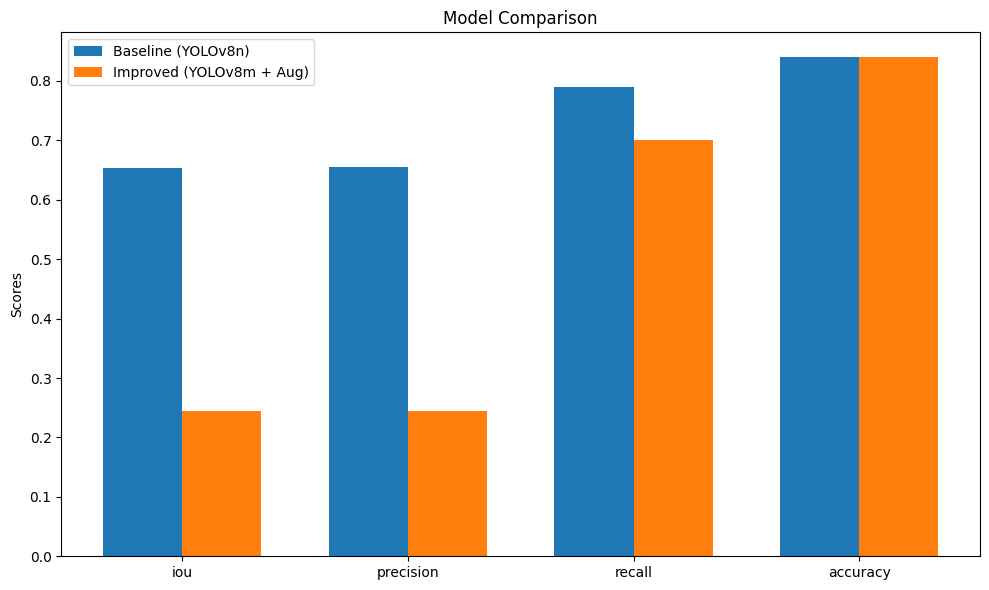

In [40]:
metrics_names = list(yolo_metrics.keys())
baseline_values = list(yolo_metrics.values())
improved_values = list(aug_yolo_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline (YOLOv8n)')
rects2 = ax.bar(x + width/2, improved_values, width, label='Improved (YOLOv8m + Aug)')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

fig.tight_layout()
plt.show()

### Выводы
 
Улучшенная модель показала результаты хуже, но это вероятно связано с тем, что из-за характеристик компьютера не удалось организовать нормальное обучение на большом количестве эпох
 